# Feature extraction
Given that we have transformed the time-dependent signal into the frequency domain, we can extract features from it.

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Tuple
from ipywidgets import widgets
ws = {'description_width': 'initial'}


def generate_signal_and_fft(T:float, fA:int, fB:int, use_hamming:bool, noisy:bool, sampling_rate:int):
    t = np.linspace(0, T, int(T*sampling_rate), endpoint=False)
    N = len(t)
    signal = 2.3 * np.cos(2*np.pi*fA*t) + 4 * np.sin(2*np.pi*fB*t)
    hamming = np.hamming(N) if use_hamming else np.ones(N)
    noise = np.random.randn(N) if noisy else 0
    noisy_signal = (signal + noise)*hamming
    fft = np.fft.rfft(noisy_signal)
    frequencies = np.fft.rfftfreq(len(noisy_signal), d=1./sampling_rate)
    return (t, signal), (frequencies, fft)

We can now extract some features from this plot, like the expected value $E[\vert\hat x\vert]=\frac{1}{N}\sum_{n=0}^{N-1} \vert \hat x_n \vert$ of the amplitude, $y=\vert \hat x \vert$, $y_n=\vert \hat x_n \vert$.

In [2]:
(t, signal), (frequencies, fft) = generate_signal_and_fft(T=10, fA=1, fB=3, 
                                                          use_hamming=True, noisy=False, sampling_rate=32)
y = np.abs(fft)
mu = np.sum(y)/len(y)

The variance of the signal is $\mathrm{Var}[y]=E[(y - E(y))^2]=\frac{1}{N}\sum_{n=0}^{N-1} \left( \hat y_n - \frac{1}{N}\sum_{n=0}^{N-1} y_n \right)^2$


In [3]:
sigma = np.sum((y -mu)**2)/len(y)

We print the two features

In [4]:
print(f"Expected frequency amplitude {mu:.2e}, frequency variance {sigma:.2e}")

Expected frequency amplitude 6.27e+00, frequency variance 1.30e+03


We can also compute the RMS value of the Power Spectral density for $N$ number of bands

In [5]:
@widgets.interact(
    use_hamming=widgets.Checkbox(value=True, description="Hamming"),
    noisy_signal=widgets.Checkbox(value=True, description="Noise"),
    sampling_rate=widgets.ToggleButtons(options=[20000, 40001],description="Sampling rate (Hz)", style=ws),
    fA=widgets.Select(options=[100,1000,5000], value=100, description='fA', disabled=False),
    fB=widgets.Select(options=[500,8000,9000], value=8000, description='fB', disabled=False),
    N=widgets.IntSlider(4, min=1, max=33, description="Number of bins",style=ws))
def RMS_PSD(sampling_rate:int, use_hamming:bool, noisy_signal:bool, N:int, fA:int, fB:int):
    """
    Compute the root mean square of the power spectral density of 
    a discrete Fourier series by subdividing the frequencies
    into `N` number of bins
    """
    T = 1
    (t, signal), (frequencies, fft) = generate_signal_and_fft(T, fA, fB, use_hamming, noisy_signal, sampling_rate)
    df = frequencies[1] - frequencies[0]
    f_per_band = len(fft)//N
    rem = len(fft)%N
    freq_per_band = np.full(N, f_per_band, dtype=np.int32)
    freq_per_band[:rem]+=1
    offsets= np.zeros(N+1, dtype=np.int32)
    offsets[1:] = np.cumsum(freq_per_band)
    RMS = np.zeros(N, dtype=np.float64)
    mid = np.zeros(N, dtype=np.int32)
    width = np.zeros(N, dtype=np.float64)
    for i in range(N):
        mid[i] = offsets[i] + int((offsets[i+1]-offsets[i])/2)
        width[i] = df*freq_per_band[i]
        psd = np.abs(fft[offsets[i]:offsets[i+1]])**2
        RMS[i] = np.sqrt(1/len(signal)*np.sum(psd**2))
    
    fig = plt.figure()
    plt.title(f"Root mean square of Power Spectral Density with {N} bins")
    plt.grid()
    plt.bar(frequencies[mid], RMS, width=width)
    plt.gca().set_yscale('log')

interactive(children=(ToggleButtons(description='Sampling rate (Hz)', options=(20000, 40001), style=ToggleButt…

As we can see in the previous widget, the spectral power density changes with the sampling frequency, and is a rather large number $\mathcal{O}(10^4-10^6)$. If we would like the feature to be sampling rate invariant, we would need to chose another feature.

## Sampling frequency robust feature
A more robust feature would be taking the frequency amplitudes of the signal, namely
$A(f_j)=\frac{1}{N}\vert \hat x(f_j)\vert$, where $N$ are the number of input signals, and we take the RMS over a set of bins.

In [6]:
@widgets.interact(
    use_hamming=widgets.Checkbox(value=True, description="Hamming"),
    noisy_signal=widgets.Checkbox(value=True, description="Noise"),
    sampling_rate=widgets.ToggleButtons(options=[20000, 40001],description="Sampling rate (Hz)", style=ws),
    fA=widgets.Select(options=[100,1000,5000], value=100, description='fA', disabled=False),
    fB=widgets.Select(options=[500,8000,9000], value=8000, description='fB', disabled=False),
    M=widgets.IntSlider(100, min=1, max=1000, description="Number of bins",style=ws))
def amplitude_bins(sampling_rate:int, use_hamming:bool, noisy_signal:bool, M:int, fA:int, fB:int):
    T = 2
    (t, signal), (frequencies, fft) = generate_signal_and_fft(T, fA, fB, use_hamming, noisy_signal, sampling_rate)
    N = len(signal)

    # Compute frequency intervals
    f_per_band = len(frequencies) // M
    rem = len(frequencies) % M
    freq_per_band = np.full(M, f_per_band, dtype=np.int32)
    freq_per_band[:rem]+=1
    
    offsets= np.zeros(M+1, dtype=np.int32)
    offsets[1:] = np.cumsum(freq_per_band)
    RMS = np.zeros(M, dtype=np.float64)
    mid = np.zeros(M, dtype=np.int32)
    width = np.zeros(M, dtype=np.float64)

    mag = 1. / N * np.abs(fft)

    fig = plt.figure()
    plt.title("Frequency Amplitude")
    plt.plot(frequencies, mag)
    plt.grid()

    RMS_amplitude = np.zeros(M, dtype=np.float64)
    for i in range(M):
        RMS_amplitude[i] = np.sqrt(1/(offsets[i+1]-offsets[i])*np.sum(mag[offsets[i]:offsets[i+1]]**2))
        mid[i] = offsets[i] + int((offsets[i+1]-offsets[i])/2)
        width[i] = (offsets[i+1]-offsets[i])/2
    plt.figure()
    plt.bar(frequencies[mid], RMS_amplitude, width)
    plt.gca().set_yscale('log')

interactive(children=(ToggleButtons(description='Sampling rate (Hz)', options=(20000, 40001), style=ToggleButt…

# Using tsfresh to compute features
Let us create a database of signals. We create a noisy signal similar to the previous databooks

In [7]:
def generate_noisy_signal(
    sample_frequency: int,
    amplitudes: npt.NDArray[np.float64],
    frequencies: npt.NDArray[np.float64],
    phases: npt.NDArray[np.float64], noise: float=1, T:float=2.):
    N = int(T*sample_frequency)
    t = np.linspace(0, T, N, endpoint=False)
    assert len(frequencies) == len(phases)
    assert len(amplitudes) == len(phases)
    n = noise*np.random.randn(len(t))
    return t, n+sum([A*np.cos(2*np.pi*f*t+p) for (A,f,p) in zip(amplitudes, frequencies, phases)])

Next, we generate a database of these signal using random sampling of amplitudes, phase shifts, noise levels and frequencies.

In [8]:
from numpy.random import MT19937, RandomState, SeedSequence
from IPython.display import display, Audio
from typing import Tuple

random_state = 123456789
rs = RandomState(MT19937(SeedSequence(random_state)))
def generate_database(num_samples:int, T:int, sample_rate:int, frequency_threshold:int)->Tuple[npt.NDArray[np.float64], npt.NDArray[np.int32]]:
    A = rs.uniform(-4, 4, size=num_samples)
    phase = np.pi * rs.random(num_samples)
    noise = rs.uniform(-2, 2, size=num_samples) * rs.random_integers(0,1, size=num_samples)
    frequencies = rs.uniform(0, sample_rate//2, size=num_samples)
    N = sample_rate * T
    database = np.zeros((num_samples*N, 3))
    label = np.zeros(num_samples, dtype=np.int32)
    for i in range(num_samples):
        t, x =  generate_noisy_signal(sample_rate, A[i:i+1], frequencies[i:i+1],
                                              phase[i:i+1],noise[i:i+1], T)
        database[i*N:(i+1)*N, 0] = i
        database[i*N:(i+1)*N, 1] = t
        database[i*N:(i+1)*N, 2] = x
        label[i] =  frequencies[i] > frequency_threshold        
    return database, label

We write the database to a Pandas dataframe and we can visualize all the signals

/tmp/ipykernel_104015/4026697445.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  noise = rs.uniform(-2, 2, size=num_samples) * rs.random_integers(0,1, size=num_samples)


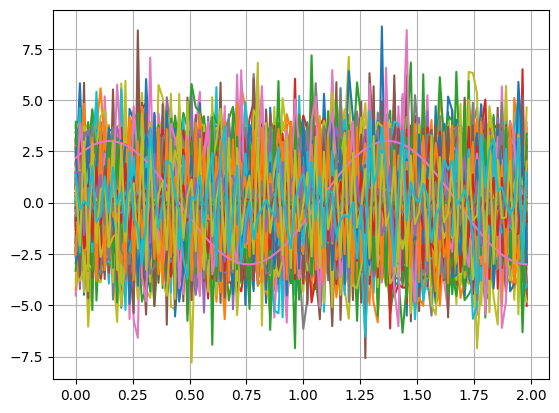

In [9]:
import pandas
num_samples = 200
T = 2
sample_rate = 55
frequency_threshold = 5
database, label = generate_database(num_samples, T, sample_rate, frequency_threshold)
df = pandas.DataFrame(database, columns=["id", "t", "x"])
for i in range(num_samples):
    plt.plot(df[df.id==i]["t"], df[df.id==i]["x"], label=f"Signal {i}")
plt.grid()
if num_samples < 50:
    plt.legend()

We use `tsfresh` to extract various features from the signal. We extract various features of the signalsdid not have any finite values

In [10]:
from tsfresh import extract_features
features = extract_features(df, column_id="id", column_sort="t")
features

Feature Extraction: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.07it/s]


,x__variance_larger_than_standard_deviation,x__has_duplicate_max,x__has_duplicate_min,x__has_duplicate,x__sum_values,x__abs_energy,x__mean_abs_change,x__mean_change,x__mean_second_derivative_central,x__median,...,x__fourier_entropy__bins_5,x__fourier_entropy__bins_10,x__fourier_entropy__bins_100,x__permutation_entropy__dimension_3__tau_1,x__permutation_entropy__dimension_4__tau_1,x__permutation_entropy__dimension_5__tau_1,x__permutation_entropy__dimension_6__tau_1,x__permutation_entropy__dimension_7__tau_1,x__query_similarity_count__query_None__threshold_0.0,x__mean_n_absolute_max__number_of_maxima_7
0.0,1.0,0.0,0.0,0.0,-9.480017,680.995982,3.467391,-0.017582,-0.038763,-0.020776,...,0.242999,0.242999,1.767412,1.769355,3.012572,4.102549,4.521932,4.631061,NaN,5.489801
1.0,1.0,0.0,0.0,0.0,1.347561,323.662369,2.442637,0.016107,0.007296,0.042114,...,0.154076,0.178831,0.356340,1.746588,1.945477,1.945647,1.945910,1.945628,NaN,2.384560
2.0,1.0,0.0,0.0,0.0,-2.174974,504.170876,2.032319,0.035615,-0.007545,0.067624,...,0.178831,0.331584,1.757618,1.781324,3.093905,4.136195,4.561541,4.644391,NaN,4.308496
3.0,1.0,0.0,0.0,0.0,22.344564,374.825357,2.311491,0.023162,0.011557,0.195623,...,0.242999,0.267754,1.421602,1.760776,2.885822,3.899056,4.450935,4.631061,NaN,4.084445
4.0,1.0,0.0,0.0,0.0,-0.756213,508.989068,1.996569,0.029897,0.017201,-0.013493,...,0.242999,0.267754,0.267754,1.572398,2.263118,2.556353,2.723877,2.892439,NaN,3.036238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195.0,0.0,0.0,0.0,0.0,0.087265,5.743163,0.372933,0.004912,-0.001202,-0.007261,...,0.178831,0.267754,0.267754,1.783408,2.176243,2.509607,2.803692,3.044104,NaN,0.322014
196.0,1.0,0.0,0.0,0.0,22.180283,522.528405,0.172922,-0.047571,-0.000926,0.373467,...,0.178831,0.178831,0.356340,0.785998,0.910725,1.036284,1.162621,1.289672,NaN,3.001517
197.0,0.0,0.0,0.0,0.0,0.336082,63.211380,1.307840,0.015717,0.001426,-0.023539,...,0.178831,0.267754,0.267754,1.735751,2.296452,2.479788,2.653105,2.827571,NaN,1.065398
198.0,1.0,0.0,0.0,0.0,0.722137,596.262771,4.116095,0.011305,0.036129,-0.006616,...,0.242999,0.267754,0.267754,1.554047,1.980437,2.015596,2.015890,2.016281,NaN,3.274599


We can also extract the most important features by using `tsfresh.select_features`, but first we remove all nan-values, see `tsfresh.impute`

In [11]:
from tsfresh import select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute, impute_dataframe_zero, impute_dataframe_range
import warnings
warnings.simplefilter("ignore")
impute(features)
features

,x__variance_larger_than_standard_deviation,x__has_duplicate_max,x__has_duplicate_min,x__has_duplicate,x__sum_values,x__abs_energy,x__mean_abs_change,x__mean_change,x__mean_second_derivative_central,x__median,...,x__fourier_entropy__bins_5,x__fourier_entropy__bins_10,x__fourier_entropy__bins_100,x__permutation_entropy__dimension_3__tau_1,x__permutation_entropy__dimension_4__tau_1,x__permutation_entropy__dimension_5__tau_1,x__permutation_entropy__dimension_6__tau_1,x__permutation_entropy__dimension_7__tau_1,x__query_similarity_count__query_None__threshold_0.0,x__mean_n_absolute_max__number_of_maxima_7
0.0,1.0,0.0,0.0,0.0,-9.480017,680.995982,3.467391,-0.017582,-0.038763,-0.020776,...,0.242999,0.242999,1.767412,1.769355,3.012572,4.102549,4.521932,4.631061,0.0,5.489801
1.0,1.0,0.0,0.0,0.0,1.347561,323.662369,2.442637,0.016107,0.007296,0.042114,...,0.154076,0.178831,0.356340,1.746588,1.945477,1.945647,1.945910,1.945628,0.0,2.384560
2.0,1.0,0.0,0.0,0.0,-2.174974,504.170876,2.032319,0.035615,-0.007545,0.067624,...,0.178831,0.331584,1.757618,1.781324,3.093905,4.136195,4.561541,4.644391,0.0,4.308496
3.0,1.0,0.0,0.0,0.0,22.344564,374.825357,2.311491,0.023162,0.011557,0.195623,...,0.242999,0.267754,1.421602,1.760776,2.885822,3.899056,4.450935,4.631061,0.0,4.084445
4.0,1.0,0.0,0.0,0.0,-0.756213,508.989068,1.996569,0.029897,0.017201,-0.013493,...,0.242999,0.267754,0.267754,1.572398,2.263118,2.556353,2.723877,2.892439,0.0,3.036238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195.0,0.0,0.0,0.0,0.0,0.087265,5.743163,0.372933,0.004912,-0.001202,-0.007261,...,0.178831,0.267754,0.267754,1.783408,2.176243,2.509607,2.803692,3.044104,0.0,0.322014
196.0,1.0,0.0,0.0,0.0,22.180283,522.528405,0.172922,-0.047571,-0.000926,0.373467,...,0.178831,0.178831,0.356340,0.785998,0.910725,1.036284,1.162621,1.289672,0.0,3.001517
197.0,0.0,0.0,0.0,0.0,0.336082,63.211380,1.307840,0.015717,0.001426,-0.023539,...,0.178831,0.267754,0.267754,1.735751,2.296452,2.479788,2.653105,2.827571,0.0,1.065398
198.0,1.0,0.0,0.0,0.0,0.722137,596.262771,4.116095,0.011305,0.036129,-0.006616,...,0.242999,0.267754,0.267754,1.554047,1.980437,2.015596,2.015890,2.016281,0.0,3.274599


We can use `tsfresh` to select the most important features.

In [15]:
labeling = pandas.Series(label)
features_filtered = select_features(features, labeling)
features_filtered

,x__longest_strike_below_mean,x__longest_strike_above_mean,"x__fft_aggregated__aggtype_""kurtosis""",x__number_crossing_m__m_0,x__autocorrelation__lag_1,x__partial_autocorrelation__lag_1,x__cid_ce__normalize_True,x__friedrich_coefficients__coeff_2__m_3__r_30,"x__fft_aggregated__aggtype_""centroid""","x__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""",...,"x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""",x__partial_autocorrelation__lag_7,x__spkt_welch_density__coeff_5,"x__fft_coefficient__attr_""angle""__coeff_51","x__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",x__autocorrelation__lag_4,"x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",x__partial_autocorrelation__lag_2,"x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max"""
0.0,3.0,4.0,47.305330,74.0,-0.414876,-0.414876,17.576933,-1.736314,29.567758,0.023150,...,-0.681258,0.153288,2.253723e+00,-107.720381,1.408824,6.079911,-0.307901,3.461825,-0.072661,-1.280760
1.0,2.0,2.0,467.738582,62.0,-0.226708,-0.226708,16.378044,-1.134666,31.774841,0.014853,...,-0.005758,1.008106,1.008023e-07,177.580003,0.000000,2.880261,0.621362,2.252786,-1.002209,0.010375
2.0,6.0,7.0,21.048656,39.0,0.326167,0.326167,12.101496,-0.474042,26.429267,0.047574,...,-1.363621,-0.119519,6.846636e-01,78.749591,1.418402,4.853526,-0.173868,2.304101,0.136153,-0.900141
3.0,3.0,4.0,46.295266,59.0,-0.200616,-0.200616,16.210081,-1.059947,29.066786,0.017699,...,0.351308,0.139165,4.824504e+00,-115.397288,0.287056,2.736603,0.342309,2.231208,-0.659987,0.117842
4.0,3.0,3.0,214.137177,37.0,0.471971,0.471971,10.730244,-0.512440,20.184813,0.012198,...,0.295142,-5.043970,1.344983e-07,170.358176,0.180577,4.384676,-0.379030,2.711404,-1.002363,0.000463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195.0,2.0,2.0,1314.868088,79.0,-0.646493,-0.646493,18.925896,-1.614858,38.355190,0.000970,...,-0.003028,-0.908658,6.209388e-11,-177.070959,0.000000,0.052897,-0.948858,0.291965,-0.995497,0.000004
196.0,35.0,32.0,5.579671,3.0,0.991375,0.991375,0.930424,0.000655,10.953609,0.073392,...,-2.680783,-0.157337,2.786070e-02,-6.670315,0.064193,0.255560,0.913882,1.412429,-0.511472,-2.490259
197.0,2.0,2.0,1363.539350,89.0,-0.833503,-0.833503,19.975004,-1.870551,42.484622,0.000280,...,-0.011952,-0.724243,5.521925e-10,-175.997891,0.000000,0.579406,-0.696150,0.978643,-0.998972,0.000237
198.0,2.0,2.0,1272.456679,94.0,-0.906726,-0.906726,20.416214,-1.933993,43.444862,0.007190,...,0.410851,0.924919,1.358987e-10,-73.376073,0.000000,5.274976,-0.221599,2.994741,-1.076547,0.052325


We can also use `extract_relevant_features` directly on the input data.

In [16]:
labeling = pandas.Series(label)
features_filtered_direct = extract_relevant_features(df, labeling, column_id='id', column_sort='t')
features_filtered_direct

Feature Extraction: 100%|█████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.21it/s]


,x__longest_strike_below_mean,x__longest_strike_above_mean,"x__fft_aggregated__aggtype_""kurtosis""",x__number_crossing_m__m_0,x__autocorrelation__lag_1,x__partial_autocorrelation__lag_1,x__cid_ce__normalize_True,x__friedrich_coefficients__coeff_2__m_3__r_30,"x__fft_aggregated__aggtype_""centroid""","x__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""",...,"x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""",x__partial_autocorrelation__lag_7,x__spkt_welch_density__coeff_5,"x__fft_coefficient__attr_""angle""__coeff_51","x__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",x__autocorrelation__lag_4,"x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",x__partial_autocorrelation__lag_2,"x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max"""
0.0,3.0,4.0,47.305330,74.0,-0.414876,-0.414876,17.576933,-1.736314,29.567758,0.023150,...,-0.681258,0.153288,2.253723e+00,-107.720381,1.408824,6.079911,-0.307901,3.461825,-0.072661,-1.280760
1.0,2.0,2.0,467.738582,62.0,-0.226708,-0.226708,16.378044,-1.134666,31.774841,0.014853,...,-0.005758,1.008106,1.008023e-07,177.580003,0.000000,2.880261,0.621362,2.252786,-1.002209,0.010375
2.0,6.0,7.0,21.048656,39.0,0.326167,0.326167,12.101496,-0.474042,26.429267,0.047574,...,-1.363621,-0.119519,6.846636e-01,78.749591,1.418402,4.853526,-0.173868,2.304101,0.136153,-0.900141
3.0,3.0,4.0,46.295266,59.0,-0.200616,-0.200616,16.210081,-1.059947,29.066786,0.017699,...,0.351308,0.139165,4.824504e+00,-115.397288,0.287056,2.736603,0.342309,2.231208,-0.659987,0.117842
4.0,3.0,3.0,214.137177,37.0,0.471971,0.471971,10.730244,-0.512440,20.184813,0.012198,...,0.295142,-5.043970,1.344983e-07,170.358176,0.180577,4.384676,-0.379030,2.711404,-1.002363,0.000463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195.0,2.0,2.0,1314.868088,79.0,-0.646493,-0.646493,18.925896,-1.614858,38.355190,0.000970,...,-0.003028,-0.908658,6.209388e-11,-177.070959,0.000000,0.052897,-0.948858,0.291965,-0.995497,0.000004
196.0,35.0,32.0,5.579671,3.0,0.991375,0.991375,0.930424,0.000655,10.953609,0.073392,...,-2.680783,-0.157337,2.786070e-02,-6.670315,0.064193,0.255560,0.913882,1.412429,-0.511472,-2.490259
197.0,2.0,2.0,1363.539350,89.0,-0.833503,-0.833503,19.975004,-1.870551,42.484622,0.000280,...,-0.011952,-0.724243,5.521925e-10,-175.997891,0.000000,0.579406,-0.696150,0.978643,-0.998972,0.000237
198.0,2.0,2.0,1272.456679,94.0,-0.906726,-0.906726,20.416214,-1.933993,43.444862,0.007190,...,0.410851,0.924919,1.358987e-10,-73.376073,0.000000,5.274976,-0.221599,2.994741,-1.076547,0.052325
